In [358]:
import numpy as np
import pandas as pd
import nose.tools as nt
import seaborn as sns
import matplotlib.pyplot as plt

from selectinf.base import (full_targets,
                     selected_targets,
                     debiased_targets)
from selectinf.base import restricted_estimator
import regreg.api as rr

from selectinf.randomized.group_lasso_query import (group_lasso,
                                                    split_group_lasso)

# Data Cleaning

In [359]:
data_raw = pd.read_csv("data_groups_dummy_encoded.csv")

In [360]:
data_raw

,SEQN,depressed,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,...,RIAGENDR_man,DMDBORN4_US,ALQ111_dummy,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion
0,109273,1,36,0.83,21.9,2,0,7,0,0,...,1,1,1,0,0,0,1,0,0,0
1,109274,0,68,1.20,30.2,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
2,109282,0,76,3.61,26.6,1,1,8,0,0,...,1,1,1,0,1,1,1,0,1,0
3,109292,0,58,1.60,30.5,2,10,3,0,1,...,1,1,1,0,1,1,0,1,0,0
4,109293,0,44,0.02,30.1,3,7,0,0,0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5980,124814,0,64,2.00,37.5,3,1,2,0,0,...,1,1,1,0,0,0,1,0,0,0
5981,124815,0,52,5.00,29.5,1,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
5982,124817,0,67,2.19,37.9,4,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5983,124818,0,40,3.82,38.2,4,5,0,0,0,...,1,1,1,0,0,0,0,0,0,0


In [4]:
DBQ197 = data_raw[["DBQ197_never","DBQ197_often",
        "DBQ197_rarely", "DBQ197_sometimes"]].to_numpy()

In [5]:
(data_raw["ALQ111_dummy"] != 1).sum()

0

In [135]:
data_X = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy")

In [7]:
data_X.columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [8]:
data_X = data_X.to_numpy()

In [9]:
np.linalg.matrix_rank(data_X)

47

In [10]:
data_X.shape

(5985, 47)

In [11]:
design_X = np.zeros((5985,48))
design_X[:,0] = np.ones((5985,))
design_X[:,1:48] = data_X

In [12]:
np.linalg.matrix_rank(design_X)

48

In [13]:
design_X.shape

(5985, 48)

In [14]:
design_X

array([[ 1.  , 36.  ,  0.83, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 68.  ,  1.2 , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 76.  ,  3.61, ...,  0.  ,  1.  ,  0.  ],
       ...,
       [ 1.  , 67.  ,  2.19, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 40.  ,  3.82, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , 63.  ,  3.71, ...,  1.  ,  0.  ,  0.  ]])

# Construct Groups

In [15]:
data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXBMI', 'DBD895', 'DBD905', 'DBD910',
       'RIDRETH1_Mexican_American', 'RIDRETH1_Other_Hispanic',
       'RIDRETH1_Non_Hispanic_White', 'RIDRETH1_Non_Hispanic_Black',
       'DMDEDUC2_1', 'DMDEDUC2_2', 'DMDEDUC2_3', 'DMDEDUC2_4',
       'DMDMARTZ_married_living_with', 'DMDMARTZ_sep', 'INDFMMPC_1',
       'INDFMMPC_2', 'ALQ121_0', 'ALQ121_1', 'ALQ121_2', 'ALQ121_3',
       'ALQ121_4', 'ALQ121_5', 'ALQ121_6', 'ALQ121_7', 'ALQ121_8', 'ALQ121_9',
       'DBQ700_1', 'DBQ700_2', 'DBQ700_3', 'DBQ700_4', 'DBQ197_never',
       'DBQ197_rarely', 'DBQ197_sometimes', 'DBQ197_often', 'DIQ010_diabetes',
       'DIQ010_diabetes_borderline', 'RIAGENDR_man', 'DMDBORN4_US',
       'ALQ151_dummy', 'BPQ020_hypertension', 'BPQ080_high_cholesterol',
       'SMQ020_smoke', 'MCQ010_asthma', 'MCQ053_anemia',
       'MCQ092_blood_transfusion'],
      dtype='object')

In [16]:
groups = np.zeros((48,))
groups[0] = int(0) # Intercept
# Singletons
for i in range(1,7):
    groups[i] = int(i)
# RIDRETH1
groups[7:11] = int(7)
# DMDEDUC2
groups[11:15] = int(8)
# DMDMARTZ
groups[15:17] = int(9)
# INDFMMPC
groups[17:19] = int(10)
# ALQ121
groups[19:29] = int(11)
# DBQ700
groups[29:33] = int(12)
# DBQ197
groups[33:37] = int(13)
# DIQ010
groups[37:39] = int(14)
# Singletons
for i in range(39,48):
    groups[i] = int(i-24)

groups = groups.astype(int)

In [17]:
col_names = data_raw[data_raw.columns[2:50]].drop(columns="ALQ111_dummy").columns.values.tolist()
col_names = ['Intercept'] + col_names

In [18]:
# Sanity check for groupings
pd.DataFrame([groups,col_names])

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,1,2,3,4,5,6,7,7,7,...,14,15,16,17,18,19,20,21,22,23
1,Intercept,RIDAGEYR,INDFMPIR,BMXBMI,DBD895,DBD905,DBD910,RIDRETH1_Mexican_American,RIDRETH1_Other_Hispanic,RIDRETH1_Non_Hispanic_White,...,DIQ010_diabetes_borderline,RIAGENDR_man,DMDBORN4_US,ALQ151_dummy,BPQ020_hypertension,BPQ080_high_cholesterol,SMQ020_smoke,MCQ010_asthma,MCQ053_anemia,MCQ092_blood_transfusion


In [138]:
n,p = design_X.shape
scaling_cts = np.ones((p,))
scaling_cts[1:7] = design_X.std(0)[1:7]
cts_logical = np.zeros((p,))
cts_logical[1:7] = 1.

In [157]:
print(np.linalg.matrix_rank(design_X))
scaling = design_X.std(0) * np.sqrt(n)
scaling[0] = np.sqrt(n)
scaling[7:p] = np.sqrt(n)

X_standardized = design_X - (cts_logical * design_X.mean(axis = 0))
print(np.linalg.matrix_rank(X_standardized))
X_standardized = X_standardized / scaling[None, :]
print(np.linalg.matrix_rank(X_standardized))

48
48
48


In [173]:
X_standardized[10:18,45:50]

array([[0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.0129, 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ]])

 # Results

In [421]:
np.random.seed(48105)

## Fixing 'weight_frac' = 1

In [390]:
def plot_single_confidence_interval(x, point_est, interval,
                                    color='#2187bb', horizontal_line_width=0.25):

    left = x - horizontal_line_width / 2
    top = interval[0]
    right = x + horizontal_line_width / 2
    bottom = interval[1]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, point_est, 'o', color='#f44336')

def plot_full_CIs(point_ests, intervals, col_names, nonzero, title):
    plt.figure(figsize=(10,6))
    col_names = np.array(col_names)
    E_card = len(col_names[nonzero])
    selected_col_names = col_names[nonzero]
    plt.xticks(list(range(1, E_card+1)), selected_col_names,
               rotation=360-45, ha='left')
    plt.title(title)
    for j in range(E_card):
        plot_single_confidence_interval(j+1, point_est=point_ests[j],
                                        interval=intervals[j])
    plt.show()


In [422]:
Y = data_raw["depressed"]

In [373]:
def split_inference(X, Y, n, p, groups, weight_frac=1., proportion=0.67):
    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    # Solve the split lasso objective
    conv = split_group_lasso.logistic(X=X,
                                      successes=Y,
                                      trials=np.ones(n),
                                      groups=groups,
                                      weights=weights,
                                      useJacobian=True,
                                      proportion=proportion)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)
    MLestimates = result['MLE']
    pval = result['pvalue']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])

    return MLestimates, intervals, pval, nonzero

In [423]:
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        weight_frac=1,
                                                        proportion=0.67)

In [424]:
MLestimates

0   -188.584394
1    -41.553795
2     14.937968
3     16.139307
4     12.281828
5     53.350867
6    -30.655934
Name: MLE, dtype: float64

In [425]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval))

[0.     0.     0.     0.     0.4102 0.0044 0.0129]


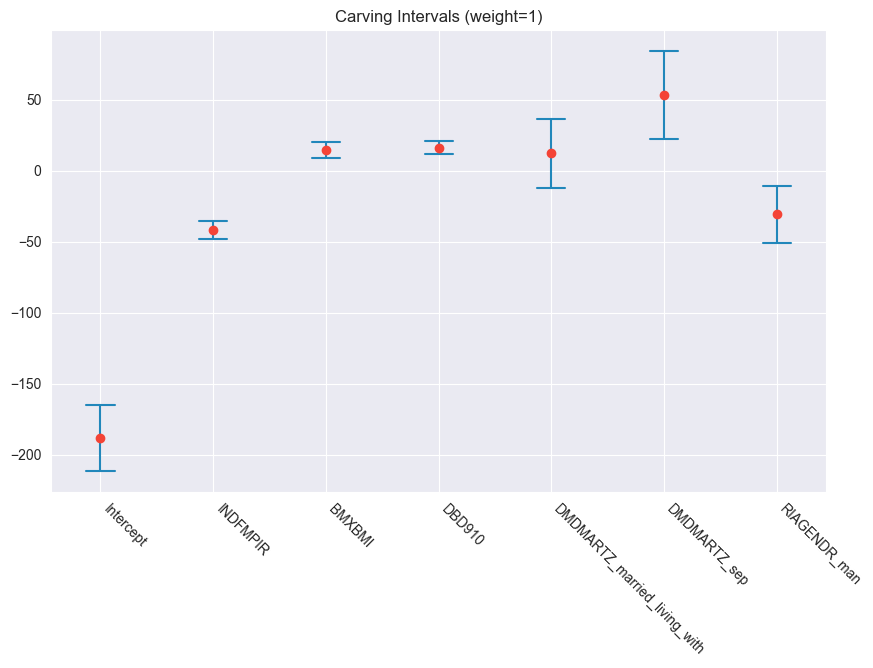

In [426]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=1)")

In [379]:
def randomized_inference(X, Y, n, p, groups, weight_frac=1., proportion=0.67,
                         randomizer_scale=None):
    hess = None
    if randomizer_scale is None:
        # Estimate randomizer covariance if not using isotropic randomization
        def estimate_hess():
            loglike = rr.glm.logistic(X, successes=Y, trials=np.ones(n))
            # For LASSO, this is the OLS solution on X_{E,U}
            beta_full = restricted_estimator(loglike, np.array([True] * p))
            def pi_hess(x):
                return np.exp(x) / (1 + np.exp(x)) ** 2

            # Calculation the asymptotic covariance of the MLE
            W = np.diag(pi_hess(X @ beta_full))

            return X.T @ W @ X * (1 - proportion) / proportion
        hess = estimate_hess()

    # Setup tuning parameters
    sigma_ = np.std(Y)
    weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    weights[0] = 0

    if hess is not None:
        # Estimated randomization covariance
        print("Estimated hessian used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                cov_rand = hess)
    else:
        # Isotropic
        print("Isotropic randomization used.")
        conv = group_lasso.logistic(X=X,
                                successes=Y,
                                trials=np.ones(n),
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                randomizer_scale=randomizer_scale * sigma_)
    signs, soln = conv.fit()
    nonzero = signs != 0

    conv.setup_inference(dispersion=1)

    target_spec = selected_targets(conv.loglike,
                                   conv.observed_soln,
                                   dispersion=1)

    result = conv.inference(target_spec,
                            method='selective_MLE',
                            level=0.9)

    pval = result['pvalue']
    MLestimates = result['MLE']
    intervals = np.asarray(result[['lower_confidence',
                                   'upper_confidence']])


    return MLestimates, intervals, pval, nonzero

In [427]:
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                     weight_frac=1,
                                                                     proportion=0.67)

Estimated hessian used.


In [428]:
MLestimates_r

0    -72.943014
1    -26.593461
2      9.718496
3     17.051789
4   -130.191206
5   -154.275820
6   -121.475905
7   -109.766142
8     40.937487
9      1.652448
Name: MLE, dtype: float64

In [429]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_r))

[0.0042 0.     0.0056 0.     0.0001 0.     0.     0.0001 0.0002 0.8972]


In [430]:
nonzero_r.sum()

10

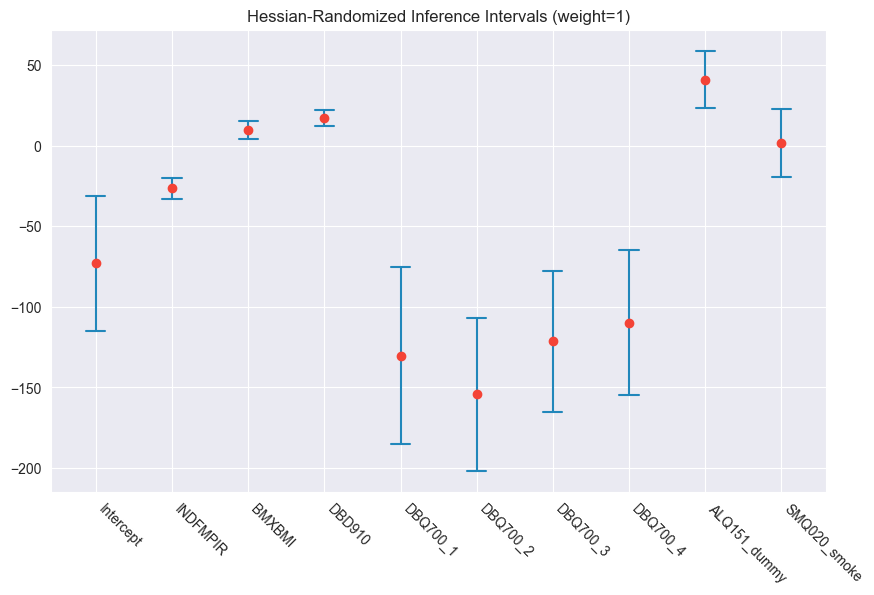

In [431]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=1)")

In [432]:
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         weight_frac=1,
                         randomizer_scale=1)

Isotropic randomization used.


In [433]:
MLestimates_iso

0    -119.436415
1     -30.688913
2       8.821191
3       9.698231
4      -4.171371
5      34.478418
6      21.549818
7      22.162740
8     -24.960063
9       9.001319
10   -109.853131
11   -107.490803
12    -83.998183
13    -59.233154
Name: MLE, dtype: float64

In [434]:
np.set_printoptions(suppress=True, precision=4)
print(np.array(pval_iso))

[0.     0.     0.0098 0.0003 0.7934 0.0245 0.0714 0.0378 0.014  0.4644
 0.     0.     0.     0.    ]


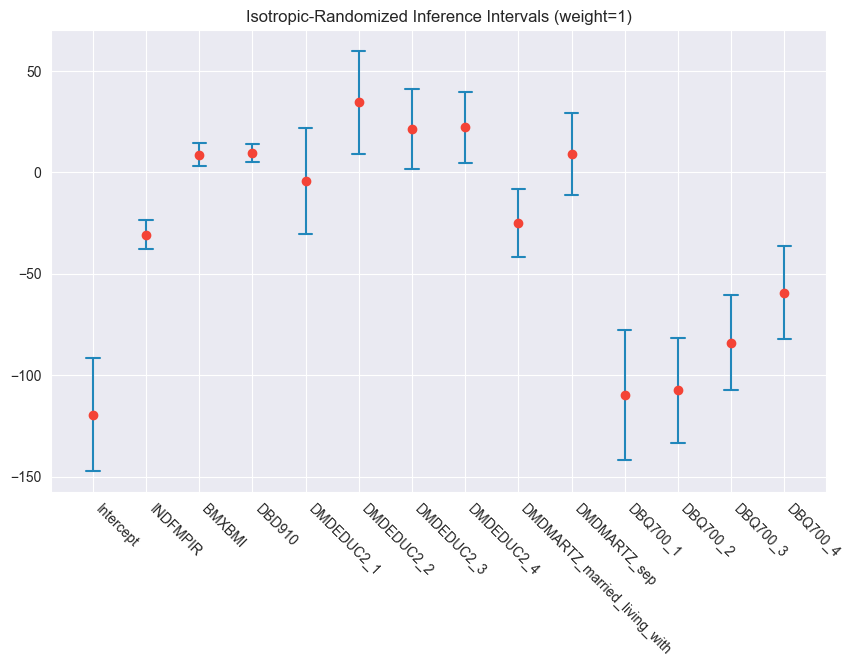

In [435]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=1)")

## Results with other values of 'weight_frac'

### weight_frac = 0.5

In [436]:
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        weight_frac=0.5,
                                                        proportion=0.67)

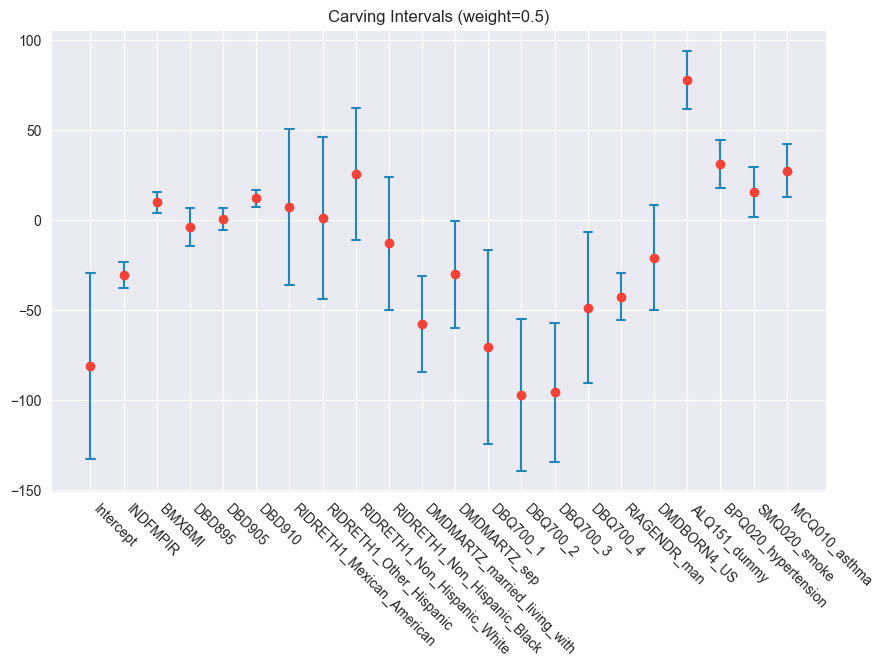

In [437]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=0.5)")

In [438]:
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                     weight_frac=0.5,
                                                                     proportion=0.67)

Estimated hessian used.


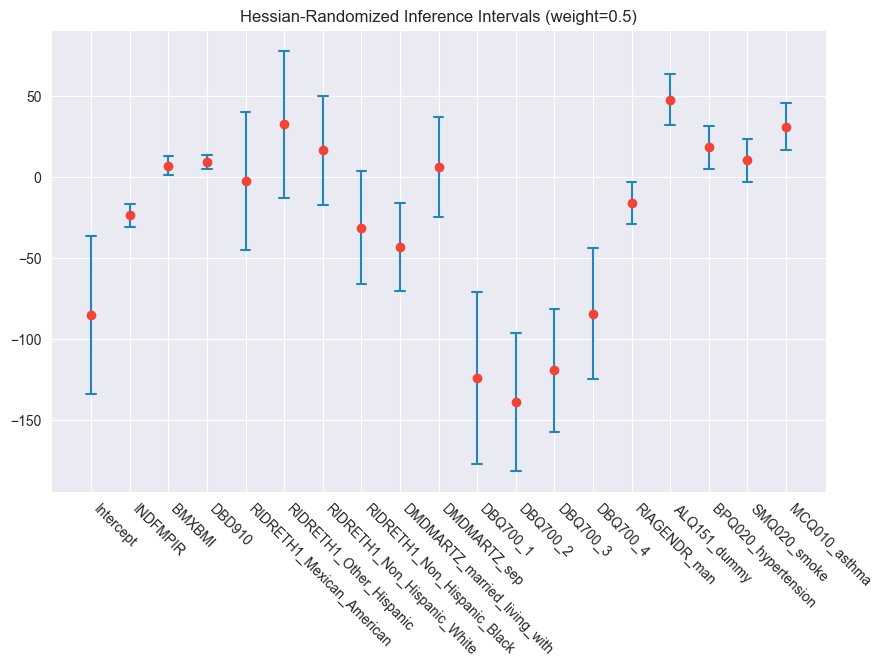

In [441]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=0.5)")

In [442]:
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         weight_frac=0.5,
                         randomizer_scale=1)

Isotropic randomization used.


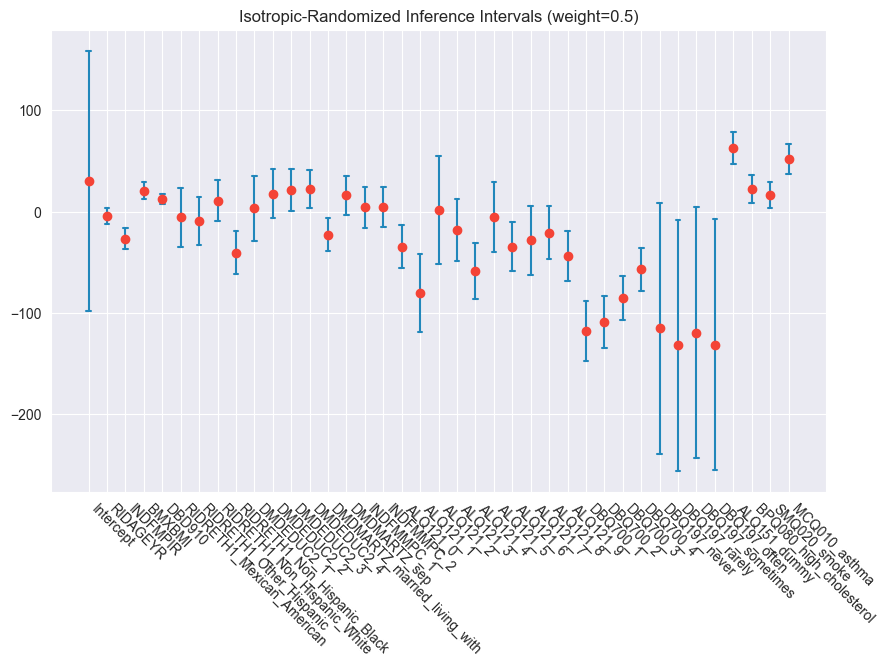

In [443]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=0.5)")

### weight_frac = 1.5

In [444]:
MLestimates, intervals, pval, nonzero = split_inference(X=X_standardized,
                                                        Y=Y, n=n, p=p,
                                                        groups=groups,
                                                        weight_frac=1.5,
                                                        proportion=0.67)

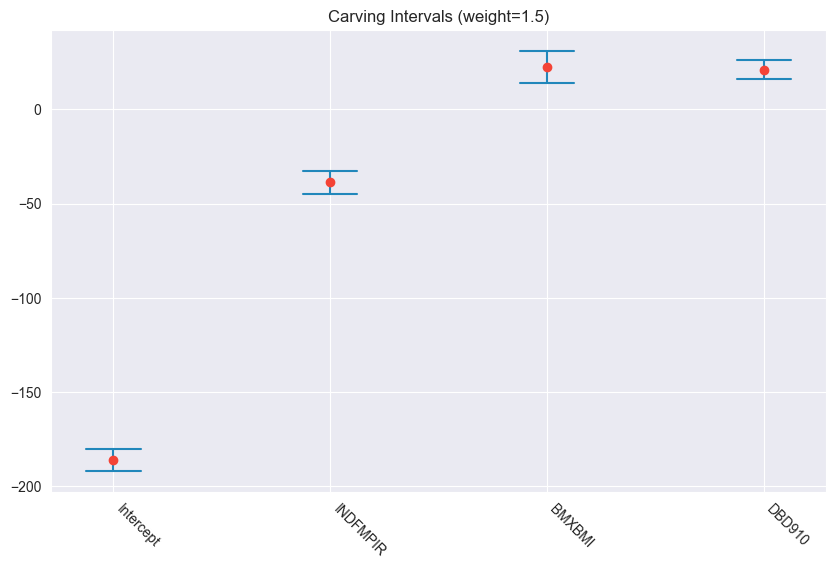

In [445]:
plot_full_CIs(MLestimates, intervals, col_names, nonzero,
              "Carving Intervals (weight=1.5)")

In [446]:
MLestimates_r, intervals_r, pval_r, nonzero_r = randomized_inference(X=X_standardized,
                                                                     Y=Y, n=n, p=p,
                                                                     groups=groups,
                                                                     weight_frac=1.5,
                                                                     proportion=0.67)

Estimated hessian used.


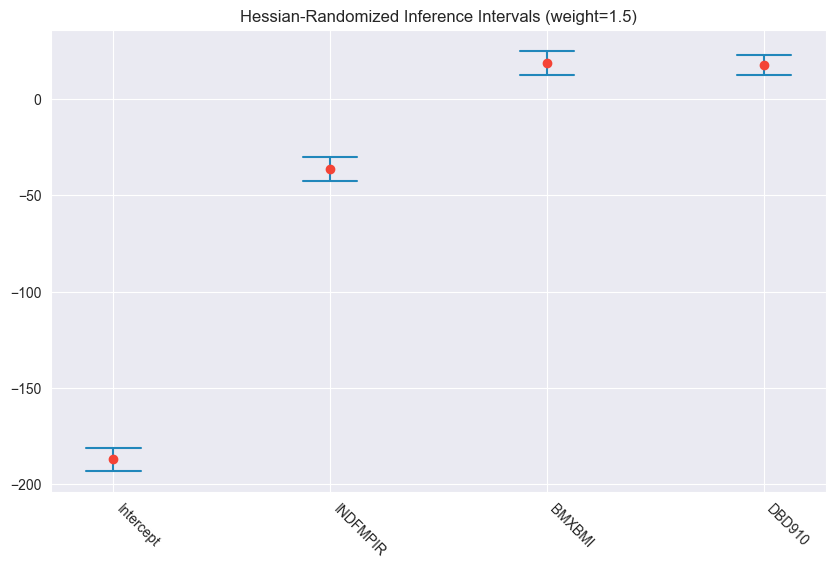

In [447]:
plot_full_CIs(MLestimates_r, intervals_r, col_names, nonzero_r,
              "Hessian-Randomized Inference Intervals (weight=1.5)")

In [448]:
MLestimates_iso, intervals_iso, pval_iso, nonzero_iso = \
    randomized_inference(X=X_standardized,
                         Y=Y, n=n, p=p,
                         groups=groups,
                         weight_frac=1.5,
                         randomizer_scale=1)

Isotropic randomization used.


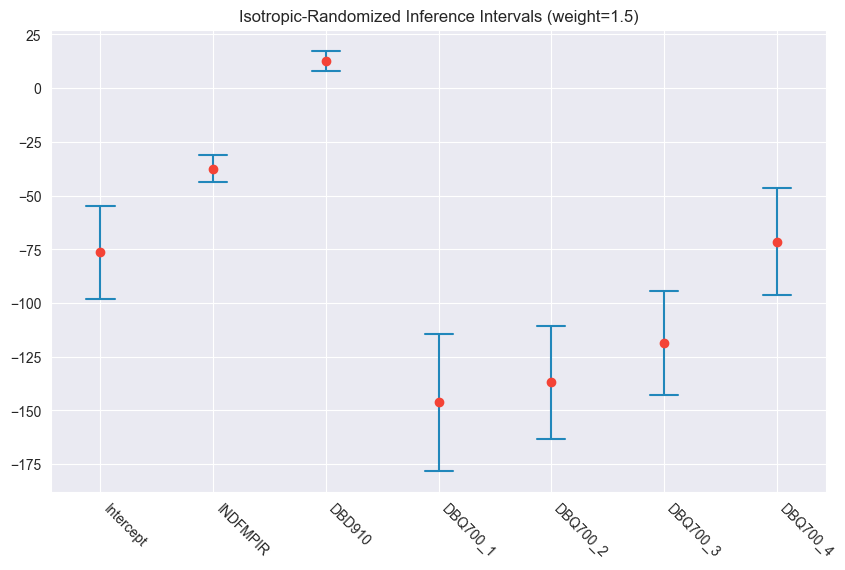

In [449]:
plot_full_CIs(MLestimates_iso, intervals_iso, col_names, nonzero_iso,
              "Isotropic-Randomized Inference Intervals (weight=1.5)")